In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
#  Step 1: Load Dataset
# ============================================
df = pd.read_csv("/content/model.csv")

print("Dataset loaded successfully!")
print("Shape:", df.shape)
print(df.head())

Dataset loaded successfully!
Shape: (99057, 21)
   year       age  gender_Female  gender_Male  race:AfricanAmerican  \
0  2020 -0.461171              1            0                     0   
1  2015 -0.595904              1            0                     0   
2  2015 -1.089926              0            1                     0   
3  2015 -0.056971              0            1                     0   
4  2016  0.437051              1            0                     1   

   race:Asian  race:Caucasian  race:Hispanic  race:Other  hypertension  ...  \
0           0               0              0           1             0  ...   
1           1               0              0           0             0  ...   
2           0               0              0           1             0  ...   
3           0               1              0           0             0  ...   
4           0               0              0           0             0  ...   

        bmi  hbA1c_level  blood_glucose_level  smo

In [6]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("diabetes")



/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


<Experiment: artifact_location='file:///content/mlruns/423312156514939961', creation_time=1764106199746, experiment_id='423312156514939961', last_update_time=1764106199746, lifecycle_stage='active', name='diabetes', tags={}>

In [7]:
import os
import mlflow

# ===== Databricks MLflow Setup =====

# 1. Databricks workspace URL
os.environ["DATABRICKS_HOST"] = "host"

# 2. Personal Access Token
os.environ["DATABRICKS_TOKEN"] = "token"

# 3. Connect notebook to Databricks MLflow
mlflow.set_tracking_uri("databricks")

# 4. Choose or create experiment
mlflow.set_experiment("path")


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1586968898094671', creation_time=1764019378208, experiment_id='1586968898094671', last_update_time=1764105923388, lifecycle_stage='active', name='/Users/alidahshan911@gmail.com/diabetes', tags={'mlflow.experiment.sourceName': '/Users/alidahshan911@gmail.com/diabetes',
 'mlflow.experimentKind': 'custom_model_development',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'alidahshan911@gmail.com',
 'mlflow.ownerId': '72130617406575'}>

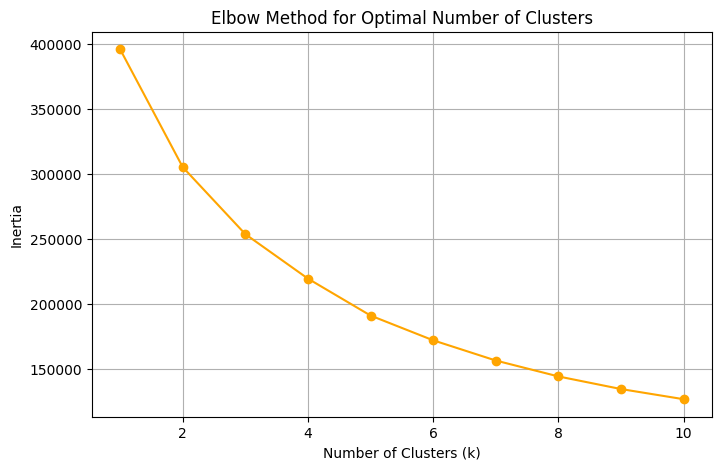

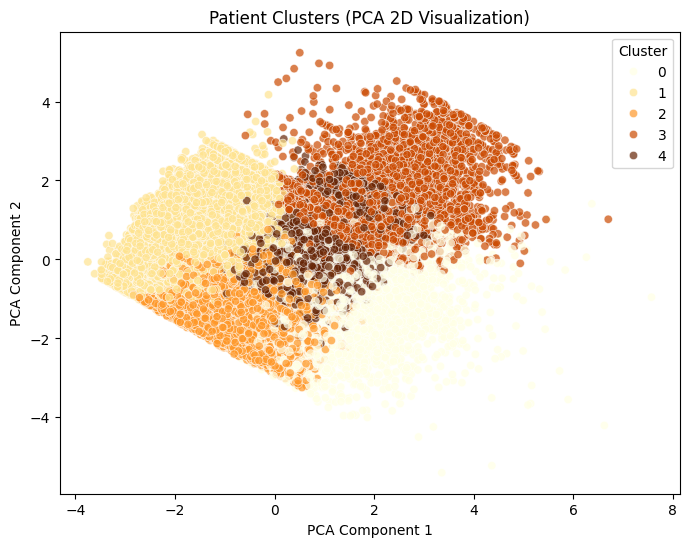


 Diabetes distribution by cluster (%):
diabetes       0      1
cluster                
0          86.78  13.22
1          99.53   0.47
2         100.00   0.00
3          46.71  53.29
4          88.92  11.08


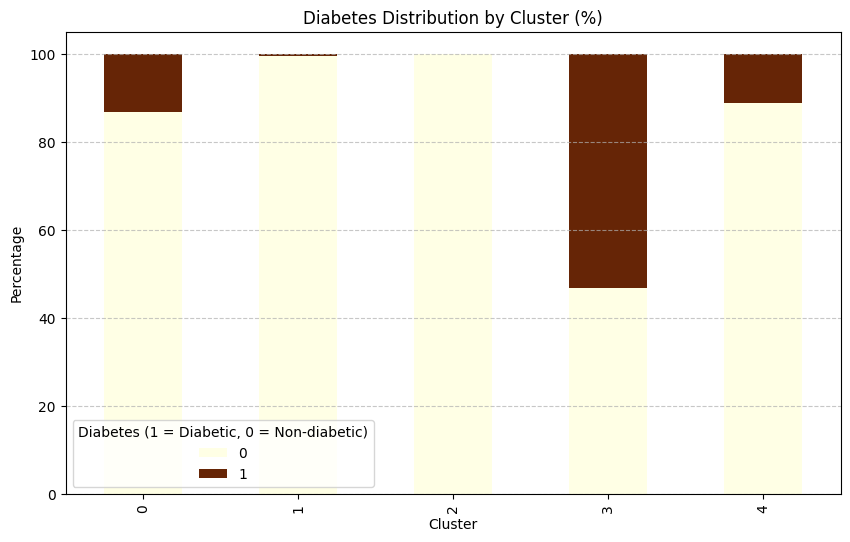


 Cluster feature summary:
          age   bmi  hbA1c_level  blood_glucose_level  diabetes
cluster                                                        
0        0.10  1.99         0.19                -0.09      0.13
1       -1.18 -0.78         0.10                -0.15      0.00
2        0.28 -0.02        -1.20                -0.15      0.00
3        0.66  0.37         0.90                 2.20      0.53
4        0.67 -0.01         0.65                -0.24      0.11


In [8]:
# ============================================
# Step 2: Select Features for Clustering
# ============================================
features_for_clustering = [
    'age',
    'bmi',
    'hbA1c_level',
    'blood_glucose_level'
]

X = df[features_for_clustering].dropna()

# ============================================
# Step 3: Scale the Data
# ============================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================
# Step 4: Elbow Method for Optimal k
# ============================================
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', color='orange')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# ============================================
# Step 5: Apply K-Means (Choose k=5 or based on elbow)
# ============================================
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# ============================================
# Step 6: PCA Visualization (2D)
# ============================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df['cluster'],
    palette='YlOrBr',
    alpha=0.7
)
plt.title('Patient Clusters (PCA 2D Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# ============================================
# Step 7: Analyze Diabetes Distribution per Cluster
# ============================================
cluster_summary = df.groupby('cluster')['diabetes'].value_counts(normalize=True).unstack().fillna(0) * 100
print("\n Diabetes distribution by cluster (%):")
print(cluster_summary.round(2))

cluster_summary.plot(kind='bar', stacked=True, colormap='YlOrBr', figsize=(10,6))
plt.title('Diabetes Distribution by Cluster (%)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Diabetes (1 = Diabetic, 0 = Non-diabetic)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ============================================
# Step 8: Cluster Feature Summary
# ============================================
summary = df.groupby('cluster')[features_for_clustering + ['diabetes']].mean().round(2)
print("\n Cluster feature summary:")
print(summary)



In [9]:
df['cluster'].value_counts()

,count
cluster,
4,29528
1,27487
2,25124
0,9774
3,7144


In [10]:
df.columns

Index(['year', 'age', 'gender_Female', 'gender_Male', 'race:AfricanAmerican',
       'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other',
       'hypertension', 'heart_disease', 'bmi', 'hbA1c_level',
       'blood_glucose_level', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current',
       'smoking_history_No Info', 'diabetes', 'cluster'],
      dtype='object')

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
import numpy as np


cluster_features = pd.get_dummies(df['cluster'], prefix='cluster')
X_with_clusters = pd.concat([df[features_for_clustering].reset_index(drop=True), cluster_features], axis=1)
y = df['diabetes']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_with_clusters)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    #"Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    mean_score = np.mean(scores)
    results.append((model_name, mean_score))
    print(f"{model_name} CV Accuracy: {mean_score:.4f}")

Logistic Regression CV Accuracy: 0.9596
Random Forest CV Accuracy: 0.9671
Gradient Boosting CV Accuracy: 0.9716
K-Nearest Neighbors CV Accuracy: 0.9665


In [15]:
results.sort(key=lambda x: x[1], reverse=True)
print("\nBest model with clustering features:", results[0])


Best model with clustering features: ('Gradient Boosting', np.float64(0.971571928620069))



Accuracy: 0.9718

Precision: 0.9984

F1 Score: 0.8038

Confusion Matrix:


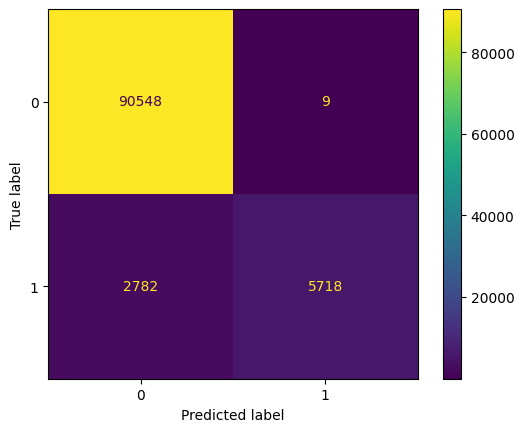

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, accuracy_score

# metrcs for the best model
best_model_name, _ = results[0]
best_model = models[best_model_name]
best_model.fit(X_scaled, y)

y_pred = best_model.predict(X_scaled)
y_true = y

accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
precision = precision_score(y_true, y_pred)
print(f"\nPrecision: {precision:.4f}")
f1 = f1_score(y_true, y_pred)
print(f"\nF1 Score: {f1:.4f}")
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
display = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
display.plot(ax=ax)
plt.show()

In [17]:
from sklearn.model_selection import GridSearchCV

# gradient boosting parameters
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 4, 5]  # Maximum depth of the individual regression estimators
}

In [18]:
# Setup GridSearchCV
grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=cv, #  same cross-validation
                           scoring='accuracy', # Use accuracy as scoring metric
                           n_jobs=-1) # Use all available cores

In [3]:
#grid search
grid_search.fit(X_scaled, y)

NameError: name 'grid_search' is not defined

In [1]:
# evaluating the model again
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_grid_model = grid_search.best_estimator_
y_pred_tuned = best_grid_model.predict(X_scaled)

accuracy_tuned = accuracy_score(y, y_pred_tuned)
print(f"\nAccuracy (after tuning): {accuracy_tuned:.4f}")
precision_tuned = precision_score(y, y_pred_tuned)
f1_tuned = f1_score(y, y_pred_tuned)
cm_tuned = confusion_matrix(y, y_pred_tuned)

print(f"\nPrecision (after  tuning): {precision_tuned:.4f}")
print(f"F1 Score (after tuning): {f1_tuned:.4f}")
print("\nConfusion Matrix (after tuning):")

display_tuned = ConfusionMatrixDisplay(cm_tuned)
fig_tuned, ax_tuned = plt.subplots()
display_tuned.plot(ax=ax_tuned)
plt.show()

NameError: name 'grid_search' is not defined

In [26]:
 with mlflow.start_run():
     mlflow.log_param("n_clusters", 5)
     mlflow.log_metric("accuracy", accuracy)
     mlflow.sklearn.log_model(model, "model")

2025/11/25 22:00:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/25 22:00:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run tasteful-mouse-536 at: https://dbc-909d033c-67c6.cloud.databricks.com/ml/experiments/1586968898094671/runs/b5f877d9c5ca4c56a069a75a81304c8b
🧪 View experiment at: https://dbc-909d033c-67c6.cloud.databricks.com/ml/experiments/1586968898094671


In [42]:
import pickle
# -----------------------------
# Save model, scaler, and columns
# -----------------------------
with open("diabetes_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save the columns used in training
model_columns = X.columns.tolist()
with open("model_columns.pkl", "wb") as f:
    pickle.dump(model_columns, f)
